In [152]:
import pandas as pd
import numpy as np
# 함수 파일 import
import import_ipynb
from function_file import *
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
data=pd.read_csv(r"C:\Users\USER\Desktop\건우\fat_predict_project\data\public_health_data_csv\profiling용.csv")

In [153]:
# 분류할 때 만들었던 특성 'fat' drop
data=data.drop('fat', axis=1)

In [154]:
# 여성만 따로 뽑아서 진행
data=data[data['sex']==2]

# (1). 타겟변수 분포 확인

c:\Users\USER\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='DW_WBT_pFT', ylabel='Density'>

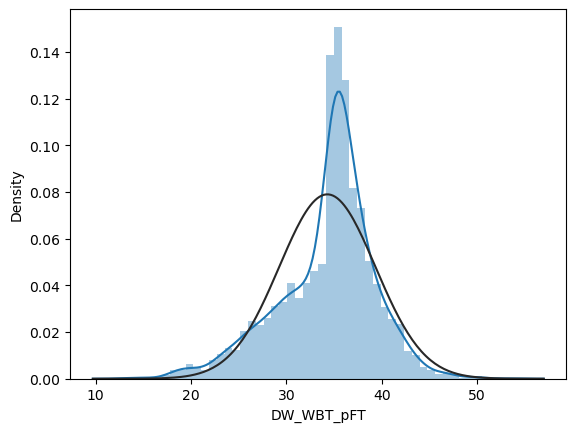

In [155]:
import seaborn as sns
from scipy import stats
from scipy.stats import norm

# distplot : 연속형 데이터의 분포를 보여주는 함수
# fit = norm -> "이 데이터가 정규분포를 따를때의 모습을 보여줌"
# => 정규분포하는지 아닌지 판단 
sns.distplot(data['DW_WBT_pFT'],fit = norm)

((array([-3.44093263, -3.19318121, -3.05594975, ...,  3.05594975,
          3.19318121,  3.44093263]),
  array([12.89069525, 14.27674371, 15.02348724, ..., 50.05088224,
         50.67885843, 53.79194459])),
 (4.956107975992062, 34.2912908055359, 0.9801863338299197))

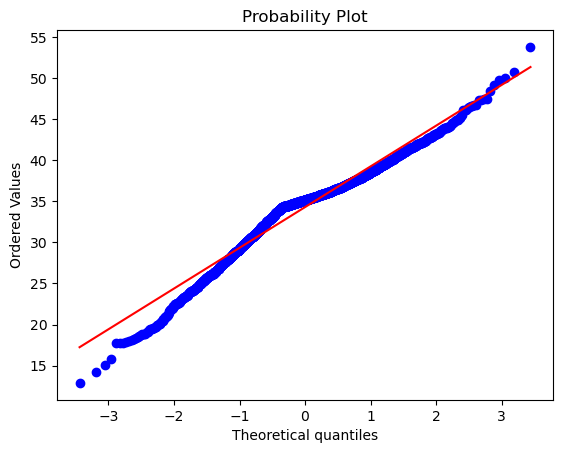

In [156]:
stats.probplot(data['DW_WBT_pFT'], plot=plt)

-> 정규화는 필요 없다고 판단

# (2) 특성 분류 (숫자형, 명목형)
-    '5. feature_filterling.ipynb' 에서 만든 특성 list import

In [157]:
import pickle

# 특성 리스트
with open('total_list.pkl', 'rb') as f:
    total_list = pickle.load(f)

for i in total_list:
    print(i)

continuous_columns
['N_WATER', 'N_FAT', 'age', 'HE_ht', 'N_INTK', 'HE_wt', 'N_EN', 'N_CHO', 'HE_wc', 'DW_WBT_pFT', 'BP8', 'DW_WBT_BMD', 'N_PROT']
category_columns
['BO1_1', 'BO1_3', 'sex', 'BO3_07', 'fat', 'DI1_2', 'BO3_09', 'BO3_12', 'DI1_dg', 'EC1_1', 'BO3_05', 'BO2_1', 'BO3_04', 'BO3_02', 'N_DIET', 'BO3_03', 'BO3_01']


In [158]:
continuous_columns= total_list[1]
# 타겟변수는 연속형에서 제외
continuous_columns.remove('DW_WBT_pFT')
category_columns=total_list[3]
category_columns.remove('fat')

# (3) 왜도 검사 및 로그화

In [159]:
from scipy.stats import skew 
skewness = data[continuous_columns].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
# 왜도 0.5이상을 높다고 판단
high_skewness = skewness[abs(skewness) > 0.75]
skew_feat = high_skewness.index
print(high_skewness)

N_CHO      3.102989
N_WATER    2.273436
N_EN       2.234055
N_FAT      2.168385
N_INTK     1.919098
N_PROT     1.551106
HE_wt      0.788222
dtype: float64


In [160]:
from scipy.special import boxcox1p
lam = 0.15 # 0에 가까울 수록 로그 변환에 가까움, 1~ 제곱근 변환, 2는 자연로그변환
for i in skew_feat:
    data[i] = boxcox1p(data[i], lam)

In [161]:
from scipy.stats import skew 
skewness = data[continuous_columns].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
# 왜도 0.5이상을 높다고 판단
high_skewness = skewness[abs(skewness) > 0.75]
skew_feat = high_skewness.index
print(high_skewness)

Series([], dtype: float64)


# (4) Modeling

-     1. 카테고리형 변수 원핫 인코딩

In [163]:
# category_columns 원핫인코딩
one_hot_list=category_columns
for i in one_hot_list:
    data[i] = data[i].astype(str)

In [164]:
# 원핫인코딩 적용한 데이터 프레임
encoded_data=pd.get_dummies(data[one_hot_list])

-     2. 연속형 변수 min_max_scaling 

In [165]:
from sklearn.preprocessing import MinMaxScaler

# Min-Max Scaler 객체 생성
scaler = MinMaxScaler()

# 선택한 컬럼들에 Min-Max Scaling 적용
data[continuous_columns] = scaler.fit_transform(data[continuous_columns])

In [166]:
# 원핫인코딩한 데이터프레임, 연속형특성 데이터프레임, 타겟변수 데이터프레임 병합
data=pd.concat((encoded_data, data[continuous_columns], data['DW_WBT_pFT']), axis=1)

-     3. 모델링 

In [167]:
X = data.drop(['DW_WBT_pFT','DW_WBT_BMD'], axis=1)
y = data['DW_WBT_pFT']

In [168]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

CV Fold 1 - MAE: 3.0572, RMSE: 3.9048, MSE: 15.2477
CV Fold 2 - MAE: 2.8479, RMSE: 3.6870, MSE: 13.5942
CV Fold 3 - MAE: 2.9248, RMSE: 3.7514, MSE: 14.0733
CV Fold 4 - MAE: 2.8963, RMSE: 3.6933, MSE: 13.6405
CV Fold 5 - MAE: 2.9422, RMSE: 3.8142, MSE: 14.5482
MAE 평균: 2.9336636552079427
RMSE 평균: 3.7701613143462707
MSE 평균: 14.220765415707206
MSE 표준편차: 0.6185344668984353
['HE_wc', 'HE_wt', 'BO2_1_1.0', 'BO1_1_3.0', 'BO1_3_2.0', 'HE_ht', 'BO1_1_2.0', 'N_DIET_2.0', 'BO3_09_0.0', 'BO3_09_1.0', 'EC1_1_1.0', 'N_INTK', 'BO3_12_0.0', 'N_PROT', 'BO2_1_4.0', 'age', 'N_FAT', 'BO3_07_1.0', 'BO3_05_1.0', 'N_CHO', 'BO2_1_2.0', 'DI1_dg_0.0', 'N_WATER', 'BO3_01_1.0', 'DI1_2_5.0', 'BP8', 'BO3_01_0.0', 'N_DIET_1.0', 'BO3_12_1.0', 'N_EN']


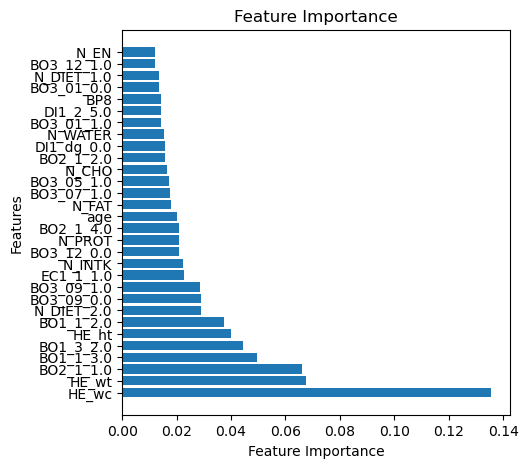

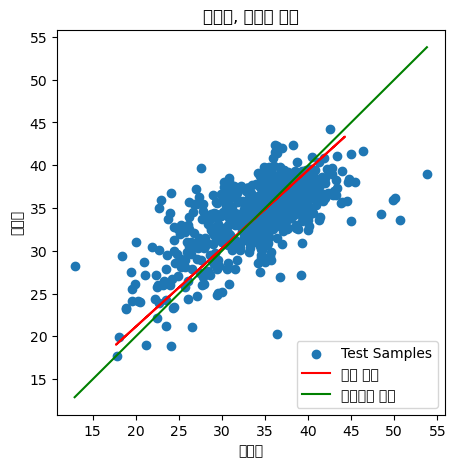

In [169]:
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

# XGBoost 모델
model_XGBoost = xgb.XGBRegressor(max_depth=3, n_estimators=600, learning_rate=0.1)
model_XGBoost.fit(X_train, y_train)
model_val(model_XGBoost, X_train, y_train)
feature_importance(model_XGBoost, X_train, 30)
visualize_model_predictions(model_XGBoost, X_test, y_test)